# Recommender Systems 2017/18

### Practice 5 - SLIM BPR


### State of the art machine learning algorithm

## A few info about gradient descent

In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.optimize import fmin

### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; choose $\alpha_k$ to minimize $f(x_k+\alpha_k s_k)$ <br>
&nbsp;&nbsp;&nbsp;    5:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha_k s_k$ <br>
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [9]:
f = lambda x: x**3-2*x**2+2

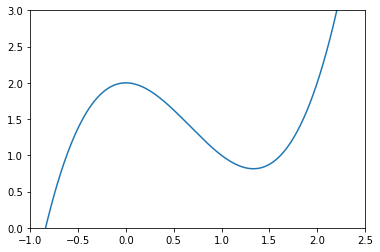

In [10]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [11]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_gradient(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    
    x_old = x_new
    
    # Gradient descent step
    s_k = -f_gradient(x_old)
    
    x_new = x_old + n_k * s_k
    
    x_list.append(x_new)
    y_list.append(f(x_new))
    
print ("Local minimum occurs at: {:.2f}".format(x_new))
print ("Number of steps:", len(x_list))

Local minimum occurs at: 1.33
Number of steps: 17


The figures below show the route that was taken to find the local minimum.

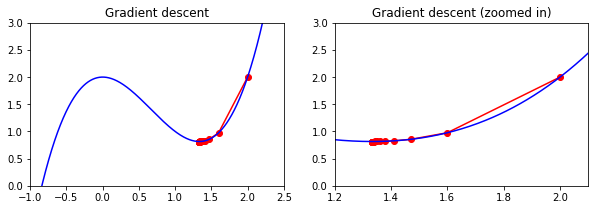

In [12]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([0,3])
plt.title("Gradient descent (zoomed in)")
plt.show()

## Let's implement SLIM BPR 

In [13]:
import time
import numpy as np

### In order to implement a SLIM BPR we need to:
#### Randomly sample the triplets (user, positive_item, negative_item)
#### Compute the score of each triplet
#### Update the similarity matrix

#### To simplify, we use a smaller dataset. More info on how to handle a bigger one later

In [14]:
from Movielens10MReader import Movielens10MReader

dataReader = Movielens10MReader()

URM_train = dataReader.get_URM_train()
URM_test = dataReader.get_URM_test()


Movielens10MReader: loading data...
Processed 1000000 cells
Processed 2000000 cells
Processed 3000000 cells
Processed 4000000 cells
Processed 5000000 cells
Processed 6000000 cells
Processed 7000000 cells
Processed 8000000 cells
Processed 1000000 cells


In [15]:
URM_train = URM_train[:,0:5000]
URM_test = URM_test[:,0:5000]
URM_train

<71568x5000 sparse matrix of type '<class 'numpy.float32'>'
	with 6772272 stored elements in Compressed Sparse Row format>

## Step 1 - Sampling

#### Create a mask of positive interactions. How to build it depends on the data

In [16]:
URM_mask = URM_train.copy()
URM_mask.data[URM_mask.data <= 3] = 0

URM_mask.eliminate_zeros()
URM_mask

<71568x5000 sparse matrix of type '<class 'numpy.float32'>'
	with 3917090 stored elements in Compressed Sparse Row format>

In [17]:
n_users = URM_mask.shape[0]
n_items = URM_mask.shape[1]


# Extract users having at least one interaction to choose from
eligibleUsers = []

for user_id in range(n_users):

    start_pos = URM_mask.indptr[user_id]
    end_pos = URM_mask.indptr[user_id+1]

    if len(URM_mask.indices[start_pos:end_pos]) > 0:
        eligibleUsers.append(user_id)
                
                

def sampleTriplet():
    
    # By randomly selecting a user in this way we could end up 
    # with a user with no interactions
    #user_id = np.random.randint(0, n_users)
    
    user_id = np.random.choice(eligibleUsers)
    
    # Get user seen items and choose one
    userSeenItems = URM_mask[user_id,:].indices
    pos_item_id = np.random.choice(userSeenItems)

    negItemSelected = False

    # It's faster to just try again then to build a mapping of the non-seen items
    while (not negItemSelected):
        neg_item_id = np.random.randint(0, n_items)

        if (neg_item_id not in userSeenItems):
            
            negItemSelected = True

    return user_id, pos_item_id, neg_item_id


In [18]:
for _ in range(10):
    print(sampleTriplet())

(66445, 4757, 4755)
(41302, 319, 2598)
(49633, 1610, 2262)
(16192, 588, 2202)
(65856, 1552, 3458)
(42391, 253, 3074)
(13967, 448, 1257)
(54368, 4226, 1156)
(71198, 2271, 1184)
(16717, 3638, 4065)


## Step 2 - Computing prediction

#### The prediction depends on the model: SLIM, Matrix Factorization... 

### We have to initialize our model. In case of SLIM it works best to initialize S as zero, in case of MF you cannot because of how the gradient is computed and you have to initialize at random. Here we initialize SLIM at random just so that we have some numbers to show

In [19]:
#similarity_matrix = np.zeros((n_items,n_items))

similarity_matrix = np.random.random((n_items,n_items))
similarity_matrix[np.arange(n_items),np.arange(n_items)] = 0

In [20]:
user_id, positive_item_id, negative_item_id = sampleTriplet()

In [21]:
positive_item_id

6

In [22]:
negative_item_id

2148

In [23]:
userSeenItems = URM_mask[user_id,:].indices
userSeenItems

array([   6,   95,  251,  349,  353,  380,  474,  589,  733,  780, 1049,
       1210, 1356, 1377, 1573, 1580, 1610, 2023, 2353], dtype=int32)

In [24]:
x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
x_j = similarity_matrix[negative_item_id, userSeenItems].sum()

print("x_i is {:.2f}, x_j is {:.2f}".format(x_i, x_j))

x_i is 7.66, x_j is 11.26


## Step 3 - Computing gradient

#### The gradient depends on the objective function: RMSE, BPR... 

In [25]:
x_ij = x_i - x_j
x_ij

-3.5994703722455261

#### The original BPR paper uses the logarithm of the sigmoid of x_ij, whose derivative is the following

In [26]:
gradient = 1 / (1 + np.exp(x_ij))
gradient

0.97338929113738248

## Step 4 - Update model

#### How to update depends on the model itself, here we have just one paramether, the similarity matrix, so we perform just one update. In matrix factorization we have two.

#### We need a learning rate, which influences how fast the model will change. Small ones lead to slower convergence but often higher results

In [27]:
learning_rate = 1e-3

similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
similarity_matrix[positive_item_id, positive_item_id] = 0

similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
similarity_matrix[negative_item_id, negative_item_id] = 0

#### Usually there is no relevant change in the scores over a single iteration

In [28]:
x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
x_j = similarity_matrix[negative_item_id, userSeenItems].sum()

print("x_i is {:.2f}, x_j is {:.2f}".format(x_i, x_j))

x_i is 7.67, x_j is 11.24


## Step 5 - Write the iterative epochs

In [29]:
import time

def epochIteration():

    # Get number of available interactions
    numPositiveIteractions = int(URM_mask.nnz*0.01)

    start_time_epoch = time.time()
    start_time_batch = time.time()

    # Uniform user sampling without replacement
    for num_sample in range(numPositiveIteractions):

        # Sample
        user_id, positive_item_id, negative_item_id = sampleTriplet()
        
        userSeenItems = URM_mask[user_id,:].indices
        
        # Prediction
        x_i = similarity_matrix[positive_item_id, userSeenItems].sum()
        x_j = similarity_matrix[negative_item_id, userSeenItems].sum()
        
        # Gradient
        x_ij = x_i - x_j

        gradient = 1 / (1 + np.exp(x_ij))
        
        # Update
        similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
        similarity_matrix[positive_item_id, positive_item_id] = 0

        similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
        similarity_matrix[negative_item_id, negative_item_id] = 0
        

        if(time.time() - start_time_batch >= 30 or num_sample == numPositiveIteractions-1):
            print("Processed {} ( {:.2f}% ) in {:.2f} seconds. Sample per second: {:.0f}".format(
                num_sample,
                100.0* float(num_sample)/numPositiveIteractions,
                time.time() - start_time_batch,
                float(num_sample) / (time.time() - start_time_epoch)))


            start_time_batch = time.time()


In [30]:
epochIteration()

Processed 3316 ( 8.47% ) in 30.00 seconds. Sample per second: 111
Processed 6620 ( 16.90% ) in 30.00 seconds. Sample per second: 110
Processed 11208 ( 28.61% ) in 30.00 seconds. Sample per second: 125
Processed 14764 ( 37.69% ) in 30.01 seconds. Sample per second: 123
Processed 19150 ( 48.89% ) in 30.00 seconds. Sample per second: 128
Processed 23422 ( 59.80% ) in 30.00 seconds. Sample per second: 130
Processed 27067 ( 69.10% ) in 30.00 seconds. Sample per second: 129
Processed 30713 ( 78.41% ) in 30.01 seconds. Sample per second: 128
Processed 34807 ( 88.86% ) in 30.00 seconds. Sample per second: 129
Processed 38401 ( 98.04% ) in 30.00 seconds. Sample per second: 128
Processed 39169 ( 100.00% ) in 5.54 seconds. Sample per second: 128


In [31]:
import scipy.sparse as sps

def similarityMatrixTopK(item_weights, forceSparseOutput = True, k=100, verbose = False, inplace=True):
    """
    The function selects the TopK most similar elements, column-wise

    :param item_weights:
    :param forceSparseOutput:
    :param k:
    :param verbose:
    :param inplace: Default True, WARNING matrix will be modified
    :return:
    """

    assert (item_weights.shape[0] == item_weights.shape[1]), "selectTopK: ItemWeights is not a square matrix"

    start_time = time.time()

    if verbose:
        print("Generating topK matrix")

    nitems = item_weights.shape[1]
    k = min(k, nitems)

    # for each column, keep only the top-k scored items
    sparse_weights = not isinstance(item_weights, np.ndarray)

    if not sparse_weights:

        idx_sorted = np.argsort(item_weights, axis=0)  # sort data inside each column

        if inplace:
            W = item_weights
        else:
            W = item_weights.copy()

        # index of the items that don't belong to the top-k similar items of each column
        not_top_k = idx_sorted[:-k, :]
        # use numpy fancy indexing to zero-out the values in sim without using a for loop
        W[not_top_k, np.arange(nitems)] = 0.0

        if forceSparseOutput:
            W_sparse = sps.csr_matrix(W, shape=(nitems, nitems))

            if verbose:
                print("Sparse TopK matrix generated in {:.2f} seconds".format(time.time() - start_time))

            return W_sparse

        if verbose:
            print("Dense TopK matrix generated in {:.2f} seconds".format(time.time()-start_time))

        return W

    else:
        # iterate over each column and keep only the top-k similar items
        data, rows_indices, cols_indptr = [], [], []

        item_weights = check_matrix(item_weights, format='csc', dtype=np.float32)

        for item_idx in range(nitems):

            cols_indptr.append(len(data))

            start_position = item_weights.indptr[item_idx]
            end_position = item_weights.indptr[item_idx+1]

            column_data = item_weights.data[start_position:end_position]
            column_row_index = item_weights.indices[start_position:end_position]

            idx_sorted = np.argsort(column_data)  # sort by column
            top_k_idx = idx_sorted[-k:]

            data.extend(column_data[top_k_idx])
            rows_indices.extend(column_row_index[top_k_idx])


        cols_indptr.append(len(data))

        # During testing CSR is faster
        W_sparse = sps.csc_matrix((data, rows_indices, cols_indptr), shape=(nitems, nitems), dtype=np.float32)
        W_sparse = W_sparse.tocsr()

        if verbose:
            print("Sparse TopK matrix generated in {:.2f} seconds".format(time.time() - start_time))

        return W_sparse

In [32]:
class SLIM_BPR_Recommender(object):
    """ SLIM_BPR recommender with cosine similarity and no shrinkage"""

    def __init__(self, URM, learning_rate = 0.01, epochs = 10):
        self.URM = URM
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.similarity_matrix = np.zeros((n_items,n_items))
        
        self.URM_mask = self.URM.copy()
        self.URM_mask.data[self.URM_mask.data <= 3] = 0
        self.URM_mask.eliminate_zeros()
        
        self.n_users = URM_mask.shape[0]
        self.n_items = URM_mask.shape[1]


        # Extract users having at least one interaction to choose from
        self.eligibleUsers = []

        for user_id in range(n_users):

            start_pos = self.URM_mask.indptr[user_id]
            end_pos = self.URM_mask.indptr[user_id+1]

            if len(self.URM_mask.indices[start_pos:end_pos]) > 0:
                self.eligibleUsers.append(user_id)



    def sampleTriplet(self):

        # By randomly selecting a user in this way we could end up 
        # with a user with no interactions
        #user_id = np.random.randint(0, n_users)

        user_id = np.random.choice(self.eligibleUsers)

        # Get user seen items and choose one
        userSeenItems = URM_mask[user_id,:].indices
        pos_item_id = np.random.choice(userSeenItems)

        negItemSelected = False

        # It's faster to just try again then to build a mapping of the non-seen items
        while (not negItemSelected):
            neg_item_id = np.random.randint(0, n_items)

            if (neg_item_id not in userSeenItems):

                negItemSelected = True

        return user_id, pos_item_id, neg_item_id


        
    def epochIteration(self):

        # Get number of available interactions
        numPositiveIteractions = int(self.URM_mask.nnz*0.01)

        start_time_epoch = time.time()
        start_time_batch = time.time()

        # Uniform user sampling without replacement
        for num_sample in range(numPositiveIteractions):

            # Sample
            user_id, positive_item_id, negative_item_id = self.sampleTriplet()

            userSeenItems = self.URM_mask[user_id,:].indices

            # Prediction
            x_i = self.similarity_matrix[positive_item_id, userSeenItems].sum()
            x_j = self.similarity_matrix[negative_item_id, userSeenItems].sum()

            # Gradient
            x_ij = x_i - x_j

            gradient = 1 / (1 + np.exp(x_ij))

            # Update
            self.similarity_matrix[positive_item_id, userSeenItems] += learning_rate * gradient
            self.similarity_matrix[positive_item_id, positive_item_id] = 0

            self.similarity_matrix[negative_item_id, userSeenItems] -= learning_rate * gradient
            self.similarity_matrix[negative_item_id, negative_item_id] = 0


            if(time.time() - start_time_batch >= 30 or num_sample == numPositiveIteractions-1):
                print("Processed {} ( {:.2f}% ) in {:.2f} seconds. Sample per second: {:.0f}".format(
                    num_sample,
                    100.0* float(num_sample)/numPositiveIteractions,
                    time.time() - start_time_batch,
                    float(num_sample) / (time.time() - start_time_epoch)))

                start_time_batch = time.time()

                
    def fit(self):
        
        for numEpoch in range(self.epochs):
            self.epochIteration()
            
        self.similarity_matrix = self.similarity_matrix.T
        
        self.similarity_matrix = similarityMatrixTopK(self.similarity_matrix, k=100)
        
        
    def recommend(self, user_id, at=None, exclude_seen=True):
        
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.similarity_matrix)
        scores = scores.toarray()

        # rank items
        ranking = scores.argsort()[::-1].squeeze()
        if exclude_seen:
            ranking = self._filter_seen(user_id, ranking)
            
        return ranking[:at]
    
    def _filter_seen(self, user_id, ranking):
        user_profile = self.URM[user_id]
        seen = user_profile.indices
        unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
        return ranking[unseen_mask]

In [33]:
recommender = SLIM_BPR_Recommender(URM_train, epochs=1)
recommender.fit()

Processed 3159 ( 8.06% ) in 30.00 seconds. Sample per second: 105
Processed 5365 ( 13.70% ) in 30.01 seconds. Sample per second: 89
Processed 9164 ( 23.40% ) in 30.00 seconds. Sample per second: 102
Processed 13858 ( 35.38% ) in 30.00 seconds. Sample per second: 115
Processed 18138 ( 46.31% ) in 30.02 seconds. Sample per second: 121
Processed 22812 ( 58.24% ) in 30.01 seconds. Sample per second: 127
Processed 27464 ( 70.11% ) in 30.01 seconds. Sample per second: 131
Processed 31604 ( 80.68% ) in 30.00 seconds. Sample per second: 132
Processed 36215 ( 92.46% ) in 30.01 seconds. Sample per second: 134
Processed 39169 ( 100.00% ) in 18.37 seconds. Sample per second: 136


In [34]:

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):
        
        if user_id % 10000 == 0:
            print("Processed user: {} ".format(user_id))

        relevant_items = URM_test[user_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

In [28]:
evaluate_algorithm(URM_test, recommender)

Processed user: 0 
Processed user: 10000 
Processed user: 20000 
Processed user: 30000 
Processed user: 40000 
Processed user: 50000 
Processed user: 60000 
Processed user: 70000 
Recommender performance is: Precision = 0.0007, Recall = 0.0001, MAP = 0.0002


### Horrible performance!!!
#### Of course, we initialized the model as zero and performed just one epoch on a micro-subsample of the data. Being a machine learning approach, more time is needed

### Let's load the cython impementation and run some serious learning. Here I show just two epochs

In [1]:
from run_me import run_SLIM

Successfully read data
Data info:
Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000
tracks_tags (483501, 2)
  track_id     tag
0  2972914   54087
1  2972914    1757
2  2972914    1718
3  2972914  116712
4  2972914  189631
0  2750239  189631


KeyboardInterrupt: 

### What you see is:
* The initial performance with the model initialized as zero
* The performance after the first iteration

### Compared to content and collaborative k-nearest neighbor SLIM improves map significantly